In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, lfilter
from scipy import signal
import scipy.signal
from scipy.signal.windows import tukey
import h5py

In [2]:
# Função para gerar um sinal de exemplo (substitua isso pelo seu sinal real)
def generate_ecg_signal(duration=10, sampling_rate=1000, heart_rate=75):
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    ecg_signal = 0.5 * np.sin(2 * np.pi * heart_rate / 60 * t)
    return t, ecg_signal

# Função para calcular a frequência cardíaca instantânea
def calculate_instantaneous_heart_rate(peaks, sampling_rate=1000):
    rr_intervals = np.diff(peaks) / sampling_rate
    heart_rate_instantaneous = 60 / rr_intervals
    return heart_rate_instantaneous

def preprocess(x, fs=128):
    HIGHPASS_FILTER = butter(2, 1, 'high', fs=fs)
    LOWPASS_FILTER = butter(2, 40, 'low', fs=fs)
    FILTER_COEFFS = [
        np.convolve(HIGHPASS_FILTER[0], LOWPASS_FILTER[0]),
        np.convolve(HIGHPASS_FILTER[1], LOWPASS_FILTER[1])
    ]

    x = x * WINDOW
    x1 = lfilter(*FILTER_COEFFS, x, axis=1)
    x1 = (x1 - x1.mean())/x1.std()
    return np.concatenate([x1], axis=2).astype('float32')

WINDOW = np.expand_dims(tukey(1280, 0.05), axis=(0, 2))

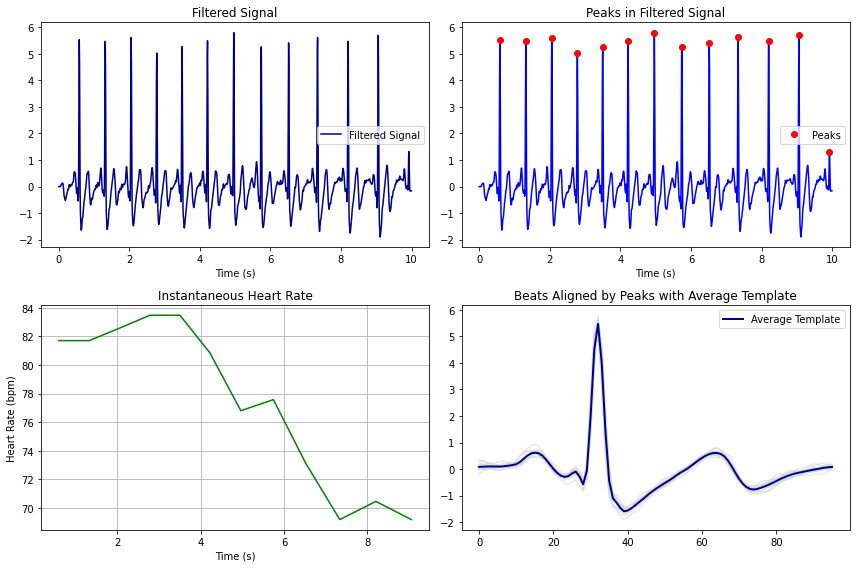

In [38]:
diretorio = 'D:/usuarios/estela.ribeiro//laudos/'
filename = '1j400008.h5'

# Open ECG - Movesense signal
f = h5py.File(diretorio + filename, "r")
signal = f['w_signal'][2]

# Parâmetros
sampling_rate=128
duration = 10
t = np.arange(0, duration, 1/sampling_rate)
lowcut = 1.0  # Frequência de corte inferior
highcut = 40.0  # Frequência de corte superior

# Cortar sinal para apenas 10 segundos
# Trim signal to 10 s (1280 samples)
cut_signal = signal[:1280].reshape(-1,1280,1)
ecg_signal = cut_signal[0]

# Aplicar filtro passa-banda
filtered_signal = preprocess(ecg_signal)

ecg_signal = ecg_signal[:,0]
filtered_signal = filtered_signal[0,:,0]

# Encontrar picos no sinal bruto
peaks, _ = find_peaks(filtered_signal,height=0.2, distance=sampling_rate / 2)

# Calcular a frequência cardíaca instantânea
heart_rate_instantaneous = calculate_instantaneous_heart_rate(peaks, sampling_rate)

# Criar subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Subplot 1: Sinal filtrado
#axs[0, 0].plot(t, ecg_signal, label='Raw Signal', color='lightblue')
axs[0, 0].plot(t, filtered_signal, label='Filtered Signal', color='darkblue')
axs[0, 0].set_title('Filtered Signal')
axs[0, 0].set_xlabel('Time (s)')
axs[0, 0].legend()

# Subplot 2: Picos no sinal 
axs[0, 1].plot(t, filtered_signal, color='blue')
axs[0, 1].plot(t[peaks], filtered_signal[peaks], 'ro', label='Peaks')
axs[0, 1].set_title('Peaks in Filtered Signal')
axs[0, 1].set_xlabel('Time (s)')
axs[0, 1].legend()

# Subplot 3: Frequência cardíaca instantânea
axs[1, 0].plot(t[peaks[:-1]], heart_rate_instantaneous, color='green')
axs[1, 0].set_title('Instantaneous Heart Rate')
axs[1, 0].set_xlabel('Time (s)')
axs[1, 0].set_ylabel('Heart Rate (bpm)')
axs[1, 0].grid('on')

# Subplot 4: Template de cada batimento alinhado pelo pico
# Subplot 2: Batimentos alinhados pelo pico e template médio
if len(peaks) > 0:
    templates = []

    for peak in peaks:
        lower_index = peak - int(sampling_rate /4)
        upper_index = peak + int(sampling_rate /2)

        if lower_index < 0 or upper_index >= len(filtered_signal):
            continue  # Pular para o próximo pico se o índice inferior for menor que zero ou o índice superior for maior que o comprimento do sinal

        template = np.asarray(filtered_signal[lower_index: upper_index])
        axs[1,1].plot(template, color='lightgray', alpha=0.5)
        templates.append(template)

    # Calcular o template médio
    average_template = np.mean(templates, axis=0)
    axs[1,1].plot(average_template, color='darkblue', linewidth=2, label='Average Template')
    axs[1,1].set_title('Beats Aligned by Peaks with Average Template')
    axs[1,1].legend()

# Ajustar layout
plt.tight_layout()
# Mostrar o gráfico
plt.show()